<a href="https://colab.research.google.com/github/Talendar/nevopy/blob/master/examples/xor/nevopy_xor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning the XOR logic function with NEAT

In this example, we're going to use [*NEvoPy's*](https://github.com/Talendar/nevopy) implementation of the NeuroEvolution of Augmenting Topologies (NEAT) algorithm to learn the XOR logic function (with 2 or more variables). Let's start by installing the package using *pip*:

(if you're on Google Colab, you might need to restart the notebook's runtime after the installation is complete)

In [ ]:
!pip install nevopy

Importing the necessary modules:

In [1]:
import nevopy as ne
import numpy as np

Now, let's build our dataset. Fortunately, *NEvoPy* has a utility function that takes care of this for us, so it shouldn't be too much work. We will start by using only 2 variables, but you can run experiments with larger numbers later.

In [19]:
# building the dataset
xor_inputs, xor_outputs = ne.utils.make_xor_data(2)

# visualizing
for x, y in zip(xor_inputs, xor_outputs):
    print(f"{x} -> {y}")

[0 0] -> 0
[0 1] -> 1
[1 0] -> 1
[1 1] -> 0


We must now define a *fitness function*. In the context of evolutionary computing, a fitness function (also known as *evaluation function*) evaluates how close a given solution is to the optimum solution of the desired problem. In our specific case, it will be used to evaluate how well our neural networks (genomes) are in predicting the output of the XOR function.

Our fitness function must take a genome as input and return the genome's fitness as output. The greater a genome fitness is, the higher are its chances of leaving offspring. To measure the fitness we'll be using the inverse of the squared error.

In [20]:
def fitness_function(genome, log=False):
    """ Implementation of the fitness function we're going to use.

    It simply feeds the XOR inputs to the given genome and calculates how well
    it did (based on the squared error).
    """
    # Shuffling the input, in order to prevent our networks from memorizing the
    # sequence of the answers.
    idx = np.random.permutation(len(xor_inputs))
    
    error = 0
    for x, y in zip(xor_inputs[idx], xor_outputs[idx]):
        # Resetting the cached activations of the genome (optional).
        genome.reset()

        # Feeding the input to the genome. A numpy array with the value 
        # predicted by the neural network is returned.
        h = genome.process(x)[0]

        # Calculating the squared error.
        error += (y - h) ** 2

        if log:
            print(f"IN: {x}  |  OUT: {h:.4f}  |  TARGET: {y}")

    if log:
        print(f"\nError: {error}")

    return (1 / error) if error > 0 else 0

Now, let's test our fitness function with a "random agent":

In [21]:
class RandomAgent:
    def reset(self):
        pass

    def process(self, x):
        y = np.random.randint(2)
        return np.array([y])

v = fitness_function(RandomAgent(), log=True)
print(f"Fitness: {v:2f}")

IN: [1 1]  |  OUT: 1.0000  |  TARGET: 0
IN: [0 0]  |  OUT: 1.0000  |  TARGET: 0
IN: [1 0]  |  OUT: 0.0000  |  TARGET: 1
IN: [0 1]  |  OUT: 0.0000  |  TARGET: 1

Error: 4
Fitness: 0.250000


Ok, it's neuroevolution time! Let's start by creating a new population of genomes to be evolved with NEAT. 

In this example, we will be using the default settings. If you want to try different settings, you can pass an instance of [NeatConfig](https://nevopy.readthedocs.io/en/latest/nevopy.neat.html#nevopy.neat.config.NeatConfig) to the population's constructor.

In [28]:
population = ne.neat.NeatPopulation(
    size=200,                       # number of genomes in the population
    num_inputs=len(xor_inputs[0]),  # number of input nodes in the genomes
    num_outputs=1,                  # number of output nodes in the genomes
)

Now, let's evolve the population. The `history` variable will contain useful statistics about the evolutionary process.

In [29]:
history = population.evolve(generations=64,
                            fitness_function=fitness_function)

>> GENERATION 64 SUMMARY:
. Mass extinction counter: 0 / 15
. Processing time:  0.3875s

|---------------|--------------|--------------|--------------|--------------|
|     NAME      |   CURRENT    |     PAST     |   INCREASE   | INCREASE (%) |
|===========================================================================|
| Best fitness  |   2.57E+11   |   1.01E+11   |  +1.56E+11   |   +155.23%   |
|---------------|--------------|--------------|--------------|--------------|
|Avg population |   2.96E+10   |   1.77E+10   |  +1.19E+10   |   +67.30%    |
|    fitness    |              |              |              |              |
|---------------|--------------|--------------|--------------|--------------|
|    Weight     |    70.00%    |    70.00%    |    +0.00%    |      -       |
|mutation chance|              |              |              |              |
|---------------|--------------|--------------|--------------|--------------|
|    Weight     |    10.00%    |    10.00%    |    +0

Let's now retrieve and evaluate the population's fittest genome:

In [30]:
best_genome = population.fittest()
fitness_function(best_genome, log=True)

IN: [1 1]  |  OUT: 0.0000  |  TARGET: 0
IN: [1 0]  |  OUT: 1.0000  |  TARGET: 1
IN: [0 1]  |  OUT: 1.0000  |  TARGET: 1
IN: [0 0]  |  OUT: 0.0000  |  TARGET: 0

Error: 3.889572962155391e-12


257097632498.41547

Not bad, huh? Let's visualize its topology:

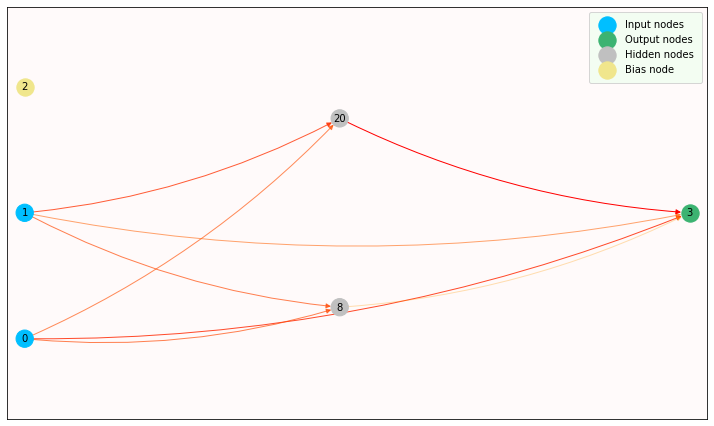

In [31]:
best_genome.visualize()

Let's now end this example by visualizing the progression of the population's fitness during the evolutionary process:

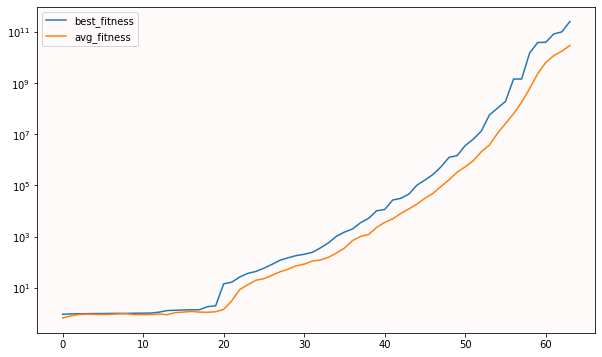

In [32]:
history.visualize()